<a href="https://colab.research.google.com/github/tiakavousi/ml/blob/main/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%201%20-%20Lesson%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Package installations
!pip install datasets transformers tensorflow pandas numpy scikit-learn
!pip install wordcloud
!pip install contractions

# Core data science and machine learning
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Deep learning imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input,
    Embedding,
    LSTM,
    Dense,
    Dropout,
    Bidirectional,
    GlobalMaxPooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Text processing
import re
import contractions
from bs4 import BeautifulSoup

# Data loading and visualization
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [14]:
# Load Yelp dataset
dataset = load_dataset("yelp_review_full")
df = pd.DataFrame(dataset['train'])

In [15]:
# Add length column
df['length'] = df['text'].apply(len)
print(df.head())

   label                                               text  length
0      4  dr. goldberg offers everything i look for in a...     534
1      1  Unfortunately, the frustration of being Dr. Go...     643
2      3  Been going to Dr. Goldberg for over 10 years. ...     495
3      3  Got a letter in the mail last week that said D...     261
4      0  I don't know what Dr. Goldberg was like before...    1143


In [16]:
# Print basic dataset information
print(f"Dataset shape: {df.shape}")
print("\nColumns in dataset:", df.columns.tolist())

# View sample data
print("\nSample of the data:")
print(df.head())

# Get dataset info and statistics
print("\nBasic information about the dataset:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Show distribution of ratings
print("\nDistribution of ratings:")
print(df['label'].value_counts().sort_index())

Dataset shape: (650000, 3)

Columns in dataset: ['label', 'text', 'length']

Sample of the data:
   label                                               text  length
0      4  dr. goldberg offers everything i look for in a...     534
1      1  Unfortunately, the frustration of being Dr. Go...     643
2      3  Been going to Dr. Goldberg for over 10 years. ...     495
3      3  Got a letter in the mail last week that said D...     261
4      0  I don't know what Dr. Goldberg was like before...    1143

Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   650000 non-null  int64 
 1   text    650000 non-null  object
 2   length  650000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 14.9+ MB
None

Missing values:
label     0
text      0
length    0
dtype: int64

Distribution of ratings:
label
0    130

In [17]:
#Column names

print(f"Feature names : {df.columns.values}")
#Check for null values

print(df.isnull().sum())

Feature names : ['label' 'text' 'length']
label     0
text      0
length    0
dtype: int64


In [18]:
# Get basic statistics of review lengths
print("\nReview length statistics:")
print(df['length'].describe())

# Optional: Distribution of lengths by rating
print("\nAverage review length by rating:")
print(df.groupby('label')['length'].mean())


Review length statistics:
count    650000.000000
mean        732.325468
std         663.721184
min           1.000000
25%         287.000000
50%         539.000000
75%         957.000000
max        5637.000000
Name: length, dtype: float64

Average review length by rating:
label
0    815.307762
1    827.625792
2    758.695454
3    680.159985
4    579.838346
Name: length, dtype: float64


In [19]:
# Print a random review with its details
random_review = df.sample(n=1).iloc[0]
print("Random Review:")
print("-" * 50)
print(f"Review Text: {random_review['text']}")
print(f"Rating: {random_review['label'] + 1} stars")  # Adding 1 because labels are 0-4
print(f"Length: {random_review['length']} characters")

Random Review:
--------------------------------------------------
Review Text: WOW! Can you say best teeth whitening experience you can ever ask for. \n\n1.Quality of service. 5 star\n2.Education about keeping my teeth white after the treatment. 5 star\n3.Relaxing and to know I am in good hands 5 star\n4. Price 5 star \n\nYou can't miss this place located right behind in n out. I live on the complete opposite side of town, and It is worth going too every time, I love it!
Rating: 5 stars
Length: 396 characters


In [20]:
len(df)


650000

<ipython-input-21-f8c7d56c15aa>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


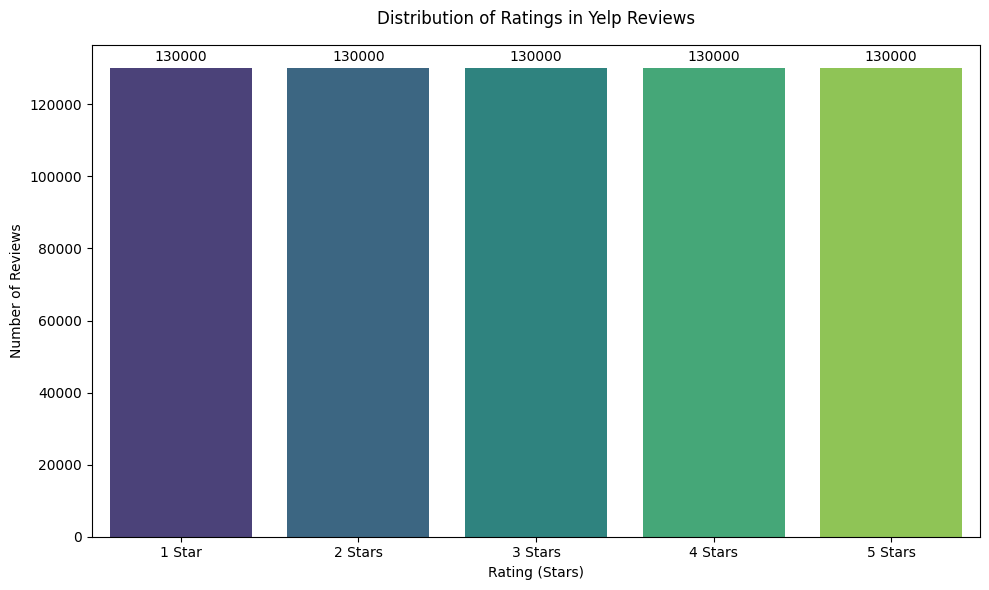


Rating Distribution:
        Count
label        
0      130000
1      130000
2      130000
3      130000
4      130000


In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, palette='viridis')

# Customize the chart
plt.title('Distribution of Ratings in Yelp Reviews', pad=15)
plt.xlabel('Rating (Stars)')
plt.ylabel('Number of Reviews')

# Adjust x-axis labels (since labels are 0-4, but represent 1-5 stars)
plt.xticks(range(5), ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'])

# Add value labels on top of each bar
for i in plt.gca().containers:
    plt.gca().bar_label(i, fmt='%d', padding=3)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Print exact counts
print("\nRating Distribution:")
print(df['label'].value_counts().sort_index().to_frame(name='Count'))

In [24]:
# Correct conversion function
def convert_to_sentiment(stars):
    if stars <= 1:       # 1-2 stars (ratings 0-1)
        return 0         # negative
    elif stars == 2:     # 3 stars (rating 2)
        return 1         # neutral
    else:               # 4-5 stars (ratings 3-4)
        return 2         # positive

# Apply corrected conversion
df['sentiment'] = df['label'].apply(convert_to_sentiment)

# Check distribution
print("\nSentiment Distribution:")
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
print(df['sentiment'].value_counts().sort_index().rename(index=sentiment_mapping))


Sentiment Distribution:
sentiment
Negative    260000
Neutral     130000
Positive    260000
Name: count, dtype: int64


<ipython-input-25-1f250679fbb4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette=colors)


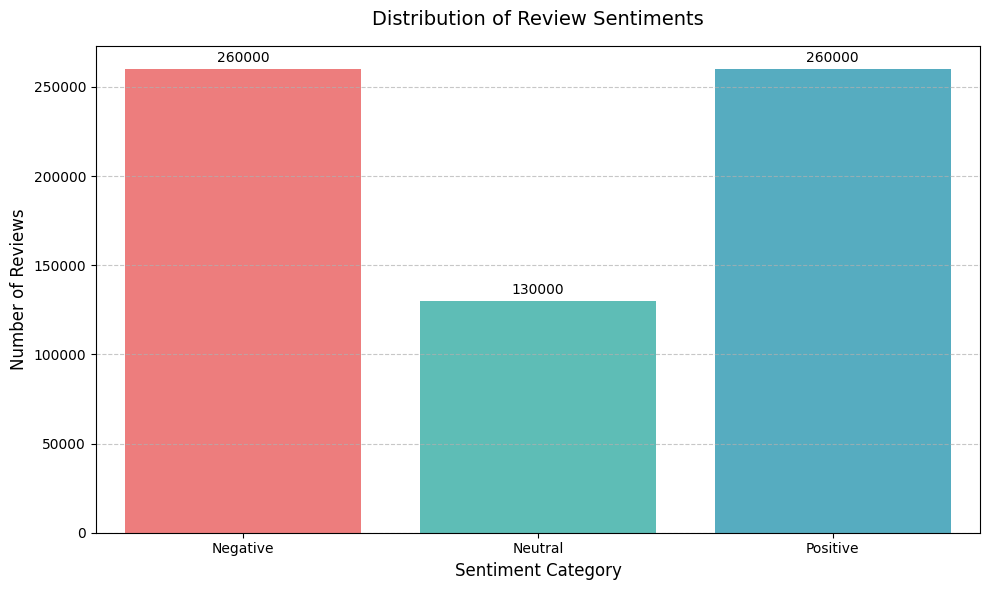


Sentiment Distribution:
sentiment
Negative    260000
Neutral     130000
Positive    260000
Name: count, dtype: int64


In [25]:
# Create bar chart
plt.figure(figsize=(10, 6))
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']  # Red for negative, teal for neutral, blue for positive
sns.countplot(x='sentiment', data=df, palette=colors)

# Customize the chart
plt.title('Distribution of Review Sentiments', pad=15, size=14)
plt.xlabel('Sentiment Category', size=12)
plt.ylabel('Number of Reviews', size=12)

# Change x-axis labels
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])

# Add value labels on top of each bar
for i in plt.gca().containers:
   plt.gca().bar_label(i, fmt='%d', padding=3)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print exact counts
print("\nSentiment Distribution:")
sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
print(df['sentiment'].value_counts().sort_index().rename(index=sentiment_mapping))

In [ ]:
# This shows:
# Neutral class is underrepresented, with only half as many samples as the other classes
# Negative and Positive classes are balanced with each other
# The ratio is approximately 2:1:2 (Negative:Neutral:Positive)

# This imbalance could affect model performance because:

# The model might not learn neutral sentiment patterns as well due to fewer examples
# The model might be biased toward predicting negative or positive over neutral
# Performance metrics need to be chosen carefully (accuracy alone wouldn't be sufficient)

In [26]:
# Get class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['sentiment']),
    y=df['sentiment']
)

# Convert to dictionary
weight_dict = dict(enumerate(class_weights))

print("Calculated class weights:")
for sentiment, weight in weight_dict.items():
    print(f"{sentiment_mapping[sentiment]}: {weight:.2f}")

'''
This will likely give weights approximately:
Negative: 1.0
Neutral:  2.0
Positive: 1.0
'''

Calculated class weights:
Negative: 0.83
Neutral: 1.67
Positive: 0.83


'\nThis will likely give weights approximately:\nNegative: 1.0\nNeutral:  2.0\nPositive: 1.0\n'


Data Split Sizes:
Training set: 520,000 reviews
Test set: 130,000 reviews

Training Set Distribution:
Negative: 208,000 (40.0%)
Neutral: 104,000 (20.0%)
Positive: 208,000 (40.0%)

Test Set Distribution:
Negative: 52,000 (40.0%)
Neutral: 26,000 (20.0%)
Positive: 52,000 (40.0%)


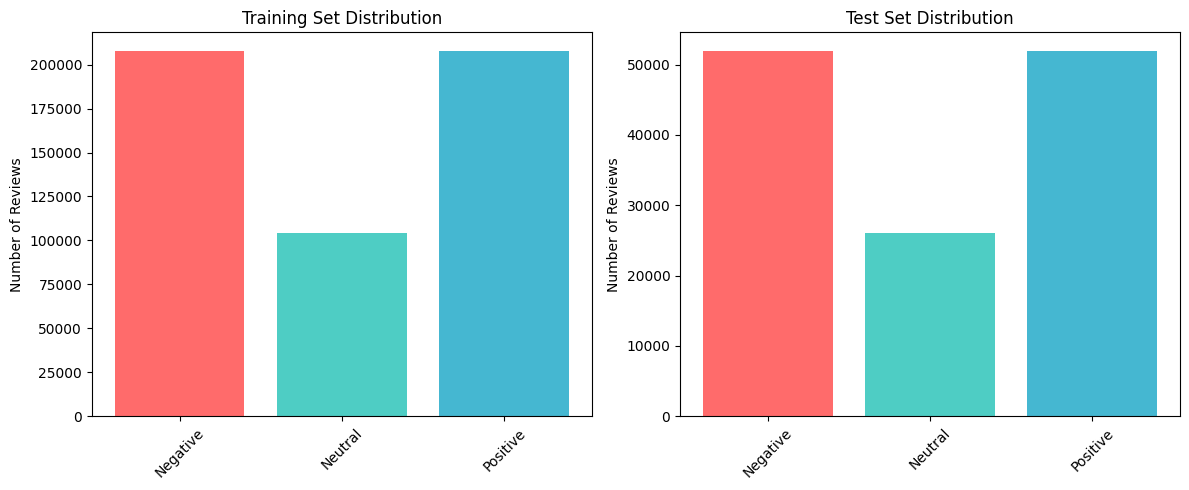

In [28]:
# First, let's prepare our features (X) and target (y)
X = df['text']  # review text
y = df['sentiment']  # sentiment labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Print the shapes
print("\nData Split Sizes:")
print(f"Training set: {X_train.shape[0]:,} reviews")
print(f"Test set: {X_test.shape[0]:,} reviews")

# Check distributions with corrected percentage calculation
print("\nTraining Set Distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for sentiment, count in train_dist.items():
    percentage = round((count/len(y_train)*100), 2)  # Fixed round function usage
    print(f"{sentiment_mapping[sentiment]}: {count:,} ({percentage}%)")

print("\nTest Set Distribution:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for sentiment, count in test_dist.items():
    percentage = round((count/len(y_test)*100), 2)  # Fixed round function usage
    print(f"{sentiment_mapping[sentiment]}: {count:,} ({percentage}%)")

# Optional: Visualize the distributions
plt.figure(figsize=(12, 5))

# Training set distribution
plt.subplot(1, 2, 1)
plt.bar(sentiment_mapping.values(), train_dist.values, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
plt.title('Training Set Distribution')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)

# Test set distribution
plt.subplot(1, 2, 2)
plt.bar(sentiment_mapping.values(), test_dist.values, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
plt.title('Test Set Distribution')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [34]:
# Initialize processed lists
X_train_processed = []
X_test_processed = []

# Process training data
for text in tqdm(X_train, desc="Processing training data"):
    # Convert to string
    text = str(text)

    # Remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # Fix contractions
    text = contractions.fix(text)

    # Convert to lowercase
    text = text.lower()

    # Remove email addresses and URLs
    text = re.sub(r'\S+@\S+|http\S+|www\S+', '', text)

    # Remove special characters but keep important punctuation
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?]', '', text)

    # Replace multiple spaces
    text = re.sub(r'\s+', ' ', text)

    X_train_processed.append(text.strip())

# Process test data (same steps)
for text in tqdm(X_test, desc="Processing test data"):
    # (same processing steps as above)
    X_test_processed.append(text.strip())

# Check a sample
print("\nOriginal:", X_train.iloc[0][:200])
print("\nProcessed:", X_train_processed[0][:200])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.8 MB/s eta 0:00:00


Processing training data:   0%|          | 0/520000 [00:00<?, ?it/s]<ipython-input-34-453795328514>:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
Processing training data:  20%|██        | 105664/520000 [00:24<01:28, 4696.55it/s]<ipython-input-34-453795328514>:17: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
Processing test data: 100%|██████████| 130000/130000 [00:00<00:00, 877102.47it/s]


Original: Lots of space and seating.  Coffee changes weekly. It's a nice location close to old town.  And the room is really open - you definitely don't feel crowded in here.

Processed: lots of space and seating. coffee changes weekly. it is a nice location close to old town. and the room is really open you definitely do not feel crowded in here.


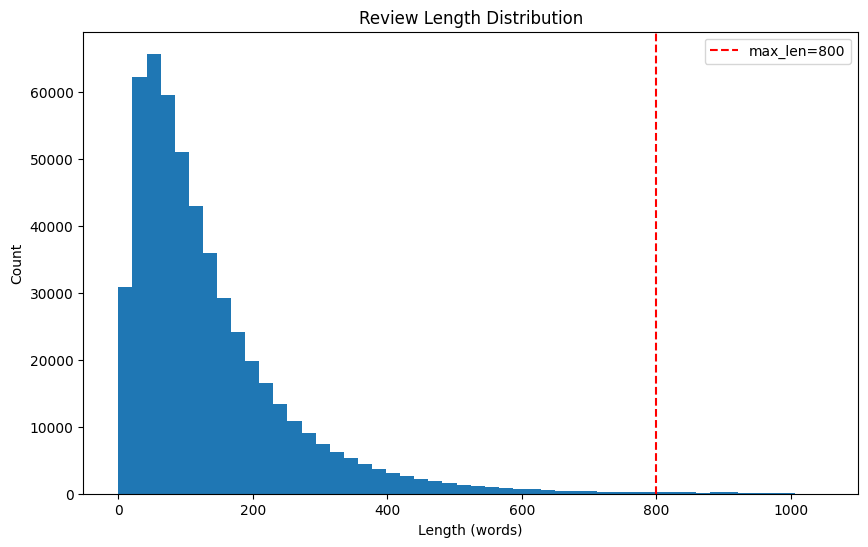


Length statistics: {'mean': 135.86967307692308, 'median': 100.0, 'std': 122.87020609432686, 'min': 0, 'max': 1048, '25th': 53.0, '75th': 178.0}


In [35]:
# Calculate lengths
train_lengths = [len(text.split()) for text in X_train_processed]

# Calculate statistics
length_stats = {
    'mean': np.mean(train_lengths),
    'median': np.median(train_lengths),
    'std': np.std(train_lengths),
    'min': np.min(train_lengths),
    'max': np.max(train_lengths),
    '25th': np.percentile(train_lengths, 25),
    '75th': np.percentile(train_lengths, 75)
}

# Plot length distribution
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50)
plt.axvline(x=300, color='r', linestyle='--', label='max_len=800')
plt.title('Review Length Distribution')
plt.xlabel('Length (words)')
plt.ylabel('Count')
plt.legend()
plt.show()

print("\nLength statistics:", length_stats)

In [ ]:
# Initialize and fit tokenizer on training data
max_words = 15000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_processed)

# Get vocabulary info
vocab_size = len(tokenizer.word_index)
print(f"\nTotal unique words: {vocab_size}")
print(f"Top 20 most common words:",
      sorted(tokenizer.word_index.items(), key=lambda x: x[1])[:20])

In [ ]:
# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_processed)
X_test_seq = tokenizer.texts_to_sequences(X_test_processed)

# Pad sequences
max_len = 300
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("\nTraining set shape:", X_train_pad.shape)
print("Test set shape:", X_test_pad.shape)

In [ ]:
# Initialize embeddings dictionary
embedding_dim = 200
embeddings_index = {}

# Load GloVe embeddings
with open('glove.6B.200d.txt', encoding='utf-8') as f:
    for line in tqdm(f, desc="Loading GloVe"):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"\nLoaded {len(embeddings_index)} word vectors")

# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
words_found = 0

for word, i in tokenizer.word_index.items():
    if i >= max_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        words_found += 1

print(f"\nFound embeddings for {words_found}/{min(max_words, len(tokenizer.word_index))} words")

In [ ]:
# Convert labels to numpy arrays if needed
y_train = np.array(y_train)
y_test = np.array(y_test)

# Create validation split from training data
from sklearn.model_selection import train_test_split

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_pad, y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

# Print final shapes
print("\nFinal data shapes:")
print(f"X_train: {X_train_final.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test_pad.shape}")
print(f"Embedding matrix: {embedding_matrix.shape}")

In [ ]:
class SentimentAnalyzer:
    def __init__(self, max_words=10000, max_len=200, embedding_dim=100):
        self.max_words = max_words
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer(num_words=max_words)
        self.model = None




    def build_model(self):
        """
        Build model architecture
        """
        input_layer = Input(shape=(self.max_len,))

        embedding = Embedding(
            self.max_words,
            self.embedding_dim,
            input_length=self.max_len
        )(input_layer)

        # Bidirectional LSTM layers
        lstm_1 = Bidirectional(LSTM(64, return_sequences=True))(embedding)
        lstm_2 = Bidirectional(LSTM(32, return_sequences=True))(lstm_1)

        # Global pooling
        pooled = GlobalMaxPooling1D()(lstm_2)

        # Dense layers with dropout
        dense_1 = Dense(64, activation='relu')(pooled)
        dropout_1 = Dropout(0.3)(dense_1)

        dense_2 = Dense(32, activation='relu')(dropout_1)
        dropout_2 = Dropout(0.2)(dense_2)

        # Output layer (3 classes)
        output_layer = Dense(3, activation='softmax')(dropout_2)

        model = Model(inputs=input_layer, outputs=output_layer)

        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def train(self, X_train, y_train, validation_data=None, epochs=10):
        """
        Train the model
        """
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        history = self.model.fit(
            X_train,
            y_train,
            epochs=epochs,
            validation_data=validation_data,
            callbacks=[early_stopping],
            batch_size=32
        )

        return history

    def predict(self, texts):
        """
        Make predictions on new texts
        """
        # Prepare input data
        sequences = self.tokenizer.texts_to_sequences(texts)
        X = pad_sequences(sequences, maxlen=self.max_len)

        # Get predictions
        predictions = self.model.predict(X)

        # Convert predictions to labels
        labels = ['negative', 'neutral', 'positive']
        results = []

        for pred in predictions:
            label_idx = np.argmax(pred)
            confidence = float(pred[label_idx])

            # If confidence is low or scores are close, consider neutral
            if confidence < 0.5 or (
                abs(pred[0] - pred[2]) < 0.2  # Difference between pos and neg
            ):
                label_idx = 1  # neutral
                confidence = float(pred[1])

            results.append({
                'sentiment': labels[label_idx],
                'confidence': confidence,
                'scores': {
                    'negative': float(pred[0]),
                    'neutral': float(pred[1]),
                    'positive': float(pred[2])
                }
            })

        return results

In [ ]:
def test_sentiment_analyzer(analyzer):
    """
    Test the sentiment analyzer with various types of reviews
    """
    test_cases = {
        "Positive Reviews": [
            "This is absolutely amazing! The best experience I've ever had!",
            "Outstanding service and incredible quality. Highly recommend to everyone!",
            "Exceeded all my expectations. Perfect in every way possible!"
        ],

        "Negative Reviews": [
            "Terrible experience. Worst service I've ever encountered.",
            "Complete waste of money. Extremely disappointing quality.",
            "Absolutely horrible. Would never recommend this to anyone."
        ],

        "Neutral Reviews": [
            "It's okay, nothing special but nothing terrible either.",
            "Average experience. Does the job but wouldn't go out of my way for it.",
            "Decent enough. Has both good and bad points, mostly mediocre."
        ],

        "Sarcastic Reviews": [
            "Oh yeah, 'AMAZING' service... if you enjoy waiting for hours! *slow clap*",
            "Wow, what a 'fantastic' experience... if you like throwing money away!",
            "Just 'perfect'... if you're a fan of complete disappointment! 👏"
        ],

        "Reviews with Negation": [
            "Not as bad as I expected, actually quite good.",
            "This isn't terrible at all, rather enjoyable.",
            "The service wasn't great, but not horrible either."
        ],

        "Reviews with Multipolarity": [
            "Great food but terrible service. Can't decide if I'll return.",
            "Amazing quality products, however extremely overpriced. Mixed feelings overall.",
            "While the interface is beautiful, the functionality is poor. Torn about this one."
        ]
    }

    print("Testing model with different types of reviews...")

    for category, reviews in test_cases.items():
        print(f"\n{'-'*20} {category} {'-'*20}")

        results = analyzer.predict(reviews)

        for review, result in zip(reviews, results):
            print(f"\nText: {review}")
            print(f"Predicted Sentiment: {result['sentiment']}")
            print(f"Confidence: {result['confidence']:.2f}")
            print("Sentiment Scores:")
            for sentiment, score in result['scores'].items():
                print(f"  {sentiment}: {score:.3f}")
            print("-" * 50)

    return test_cases

# Example usage:
def main():
    # Initialize and train your model first
    analyzer = SentimentAnalyzer()

    # Load and prepare data
    (X_train, y_train), (X_test, y_test) = analyzer.load_and_prepare_data()

    # Build and train model
    model = analyzer.build_model()
    analyzer.train(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

    # Run comprehensive tests
    test_cases = test_sentiment_analyzer(analyzer)

    # Additional analysis
    analyze_results(test_cases, analyzer)

def analyze_results(test_cases, analyzer):
    """
    Analyze model performance on different types of reviews
    """
    print("\nPerformance Analysis:")

    for category, reviews in test_cases.items():
        results = analyzer.predict(reviews)

        # Calculate average confidence
        avg_confidence = np.mean([r['confidence'] for r in results])

        # Calculate sentiment distribution
        sentiment_dist = {}
        for result in results:
            sentiment = result['sentiment']
            sentiment_dist[sentiment] = sentiment_dist.get(sentiment, 0) + 1

        print(f"\n{category}:")
        print(f"Average Confidence: {avg_confidence:.2f}")
        print("Sentiment Distribution:", sentiment_dist)

if __name__ == "__main__":
    main()

Loading Yelp dataset...
Training samples: 24000
Testing samples: 6000
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.4956 - loss: 0.9537 - val_accuracy: 0.6850 - val_loss: 0.6923
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.7241 - loss: 0.6360 - val_accuracy: 0.6903 - val_loss: 0.7049
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7856 - loss: 0.5183 - val_accuracy: 0.6893 - val_loss: 0.7438
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8360 - loss: 0.4198 - val_accuracy: 0.6725 - val_loss: 0.7561
Testing model with different types of reviews...

-------------------- Positive Reviews --------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step

Text: This is absolutely amazing! The best experience I've ever had!
Predicted Sentiment: positive
Confidence: 0.96
Sentiment Scores:
  negative: 0.001
  neutral: 0.043
  positive: 0.956
--------------------------------------------------

Text: Outstanding service and incredible quality. Highly recommend to everyone!
Predicted Sentiment: posit